In [1]:
# install kaggle package
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# copy kaggle account file 
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:20<00:00, 141MB/s]
100% 2.70G/2.70G [00:20<00:00, 138MB/s]


In [4]:
# unzip dataset
!mkdir Dataset
!unzip /content/new-plant-diseases-dataset.zip -d /content/Dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2

In [6]:
!rm -r '/content/Dataset/new plant diseases dataset(augmented)'

In [1]:
import os
import shutil
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
import seaborn as sns
import pandas as pd

In [3]:
sns.set(rc={'figure.figsize':(11,5)})

In [4]:
IMG_SIZE = [98,98]
BATCH_SIZE = 64
n_classes = 38

### Transfer-Learning Model

In [5]:
# import keras modules
from keras.utils import image_dataset_from_directory
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.mobilenet_v3 import MobileNetV3Small
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [6]:
# train set and validation set paths
train_path = 'Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_path = 'Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [7]:
# initialize keras datagen and also scale down pixels
# augmentation is included
# splitting train set in to 80:20 where 20% is test set
#
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  zoom_range=0.3,
                                   shear_range=0.2,
                                   validation_split=0.2)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_data = datagen_train.flow_from_directory(train_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                          seed=1,
                                          subset='training')

test_data = datagen_train.flow_from_directory(valid_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                        seed=1,
                                        subset='validation')

valid_data = datagen_valid.flow_from_directory(valid_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE)

Found 56251 images belonging to 38 classes.
Found 3503 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [8]:
resnet = Xception(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)
x = resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.4)(x)
prediction = Dense(n_classes, activation='softmax')(x)

for layers in resnet.layers:
    layers.trainable=False

# Set callback functions to  save the best model so far
callbacks = [ModelCheckpoint(filepath='bestTL_model.h5', monitor='val_accuracy', save_best_only=True)]
transfer_model = Model(inputs=resnet.input, outputs=prediction)
transfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [9]:
transfer_model.fit(train_data, 
                   batch_size=BATCH_SIZE, 
                   epochs=20,
                   callbacks=callbacks,
                   validation_data=valid_data)

Epoch 1/20
879/879 [==============================] - 111s 122ms/step - loss: 1.5198 - accuracy: 0.5645 - val_loss: 0.8697 - val_accuracy: 0.7285
Epoch 2/20
879/879 [==============================] - 105s 120ms/step - loss: 1.0803 - accuracy: 0.6687 - val_loss: 0.7347 - val_accuracy: 0.7697
Epoch 3/20
879/879 [==============================] - 106s 121ms/step - loss: 0.9885 - accuracy: 0.6969 - val_loss: 0.6947 - val_accuracy: 0.7814
Epoch 4/20
879/879 [==============================] - 106s 121ms/step - loss: 0.9527 - accuracy: 0.7078 - val_loss: 0.6931 - val_accuracy: 0.7819
Epoch 5/20
879/879 [==============================] - 108s 123ms/step - loss: 0.9078 - accuracy: 0.7201 - val_loss: 0.6648 - val_accuracy: 0.7873
Epoch 6/20
879/879 [==============================] - 108s 122ms/step - loss: 0.8714 - accuracy: 0.7308 - val_loss: 0.6443 - val_accuracy: 0.7928
Epoch 7/20
879/879 [==============================] - 107s 121ms/step - loss: 0.8645 - accuracy: 0.7353 - val_loss: 0.6057 -

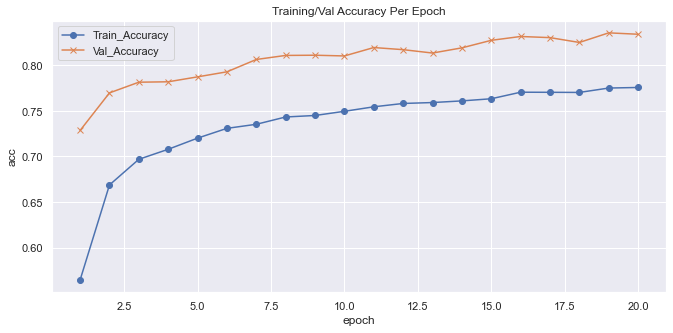

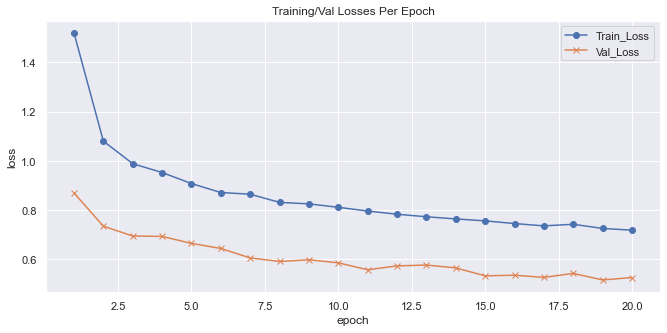

In [10]:
# plotting loss graphs w.r.t each epoch
f, ax = plt.subplots()
ax.plot([None] + transfer_model.history.history["accuracy"], 'o-')
ax.plot([None] + transfer_model.history.history["val_accuracy"], 'x-')

ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
ax.set_title('Training/Val Accuracy Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

f, ax = plt.subplots()
ax.plot([None] + transfer_model.history.history["loss"], 'o-')
ax.plot([None] + transfer_model.history.history["val_loss"], 'x-')

ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
ax.set_title('Training/Val Losses Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

### Evaluation

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import classification_report

In [12]:
# this function will evaluate trained model on validation set
def report(prediction, y_true):
    print('        ----------Classification Report Of Classes-------------')
    print(classification_report(y_true,prediction,target_names=label_names))
    print('\n        ----------Validation Data------------------')
    print('Accuarcy:',accuracy_score(y_true, prediction)* 100)
    print('Precision: {:,.2f} %'.format(precision_score(y_true, prediction, average='weighted') * 100))
    print('Recall-score: {:,.2f}'.format(recall_score(y_true, prediction, average='weighted') * 100))
    print('F1-score: {:,.2f}'.format(f1_score(y_true, prediction, average='weighted') * 100))
    cm = confusion_matrix(y_true,prediction)
    print('\n-----------Confusion Matrix------------\n')
    print(cm)
    
    plt.figure(figsize=(17,15))
    plt.imshow(cm , cmap= plt.cm.Blues_r)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks,label_names, rotation = 90)
    plt.yticks(tick_marks,label_names)
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j],'.2f'), ha='center', va='center',
                     color='black' if cm[i,j] > thresh else 'white')
    plt.show()

In [13]:
# we need label encoder of labels so getting it from saved file
import joblib
label_le = joblib.load('labels.pkl')

In [14]:
# extracting images and labels from keras datagen of valid set
valid_img = []
valid_label = []
batch_index = 0

while batch_index <= valid_data.batch_index:
    data = valid_data.next()
    valid_img.extend(data[0])
    valid_label.extend(np.argmax(data[1], axis=1))
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
valid_img = np.asarray(valid_img)

In [15]:
# load best saved model
from keras.models import load_model
best_model = load_model('bestTL_model.h5')

550/550 [==============================] - 10s 17ms/step
        ----------Classification Report Of Classes-------------
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.78      0.78      0.78       504
                                 Apple___Black_rot       0.80      0.87      0.84       497
                          Apple___Cedar_apple_rust       0.81      0.91      0.86       440
                                   Apple___healthy       0.79      0.83      0.81       502
                               Blueberry___healthy       0.83      0.85      0.84       454
          Cherry_(including_sour)___Powdery_mildew       0.93      0.94      0.94       421
                 Cherry_(including_sour)___healthy       0.91      0.94      0.92       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.83      0.83      0.83       410
                       Corn_(maize)___Common_rust_

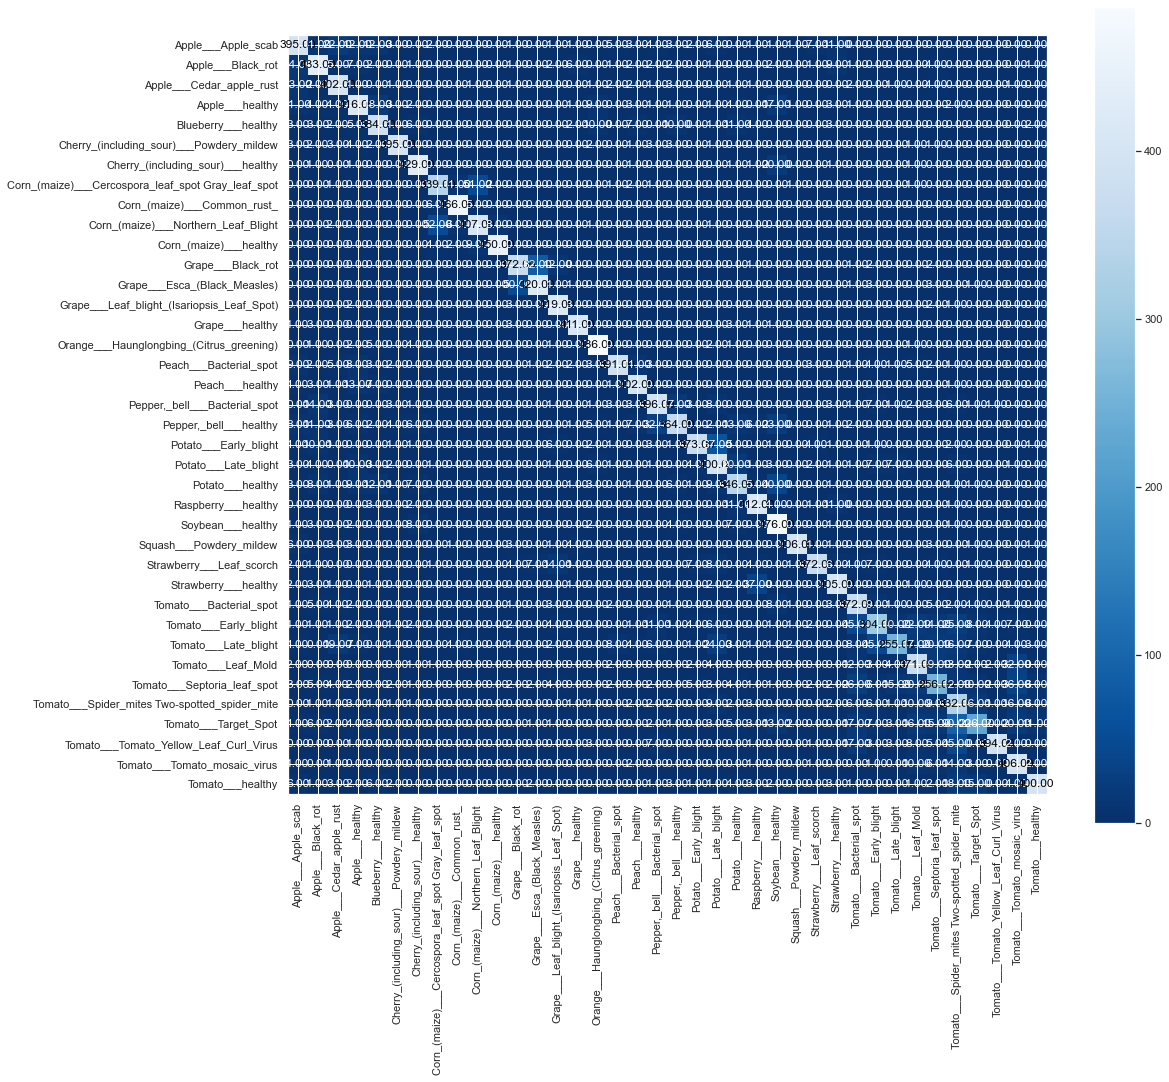

In [16]:
# predicting results of valid set from best model and evaluating the prediction

label_names = label_le.classes_
prediction = best_model.predict(valid_img)
prediction = np.argmax(prediction,axis=1)
report(prediction, valid_label)

### Post model Analysis

In [ ]:
false_pred, false_label, true_label = list(), list(), list()
for e,img in enumerate(valid_img):
    img = np.expand_dims(img, axis=0)
    predict = best_model.predict(img, verbose=0)
    predict = np.argmax(predict,axis=1)
#     predict = label_le.inverse_transform(predict)
    if predict[0] != valid_label[e]:
        false_pred.append(np.squeeze(img))
        false_label.extend(label_le.inverse_transform(predict))
        true_label.extend(label_le.inverse_transform([valid_label[e]]))

In [ ]:
print('Total False Predictions are:', len(false_label))

In [ ]:
row, col = 4,3
plt.figure(figsize=(12,20))

for elem in range(row*col):
    plt.subplot(row, col, elem+1)
    idx = np.random.choice(len(false_pred))
    plt.imshow(false_pred[idx])
    plt.xlabel("Predicted: %s"%false_label[idx] )
    plt.title("True: %s"%true_label[idx])
plt.show()

In [65]:
del valid_img
del valid_label

### Test Set Evaluation

In [17]:
# extracting images and labels from keras datagen of test set
test_img = []
test_label = []
batch_index = 0

while batch_index <= test_data.batch_index:
    data = test_data.next()
    test_img.extend(data[0])
    test_label.extend(np.argmax(data[1], axis=1))
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
test_img = np.asarray(test_img)

110/110 [==============================] - 2s 20ms/step
        ----------Classification Report Of Classes-------------
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.78      0.73      0.75       100
                                 Apple___Black_rot       0.70      0.75      0.72        99
                          Apple___Cedar_apple_rust       0.80      0.85      0.82        88
                                   Apple___healthy       0.72      0.76      0.74       100
                               Blueberry___healthy       0.78      0.74      0.76        90
          Cherry_(including_sour)___Powdery_mildew       0.90      0.88      0.89        84
                 Cherry_(including_sour)___healthy       0.82      0.92      0.87        91
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.79      0.81        82
                       Corn_(maize)___Common_rust_ 

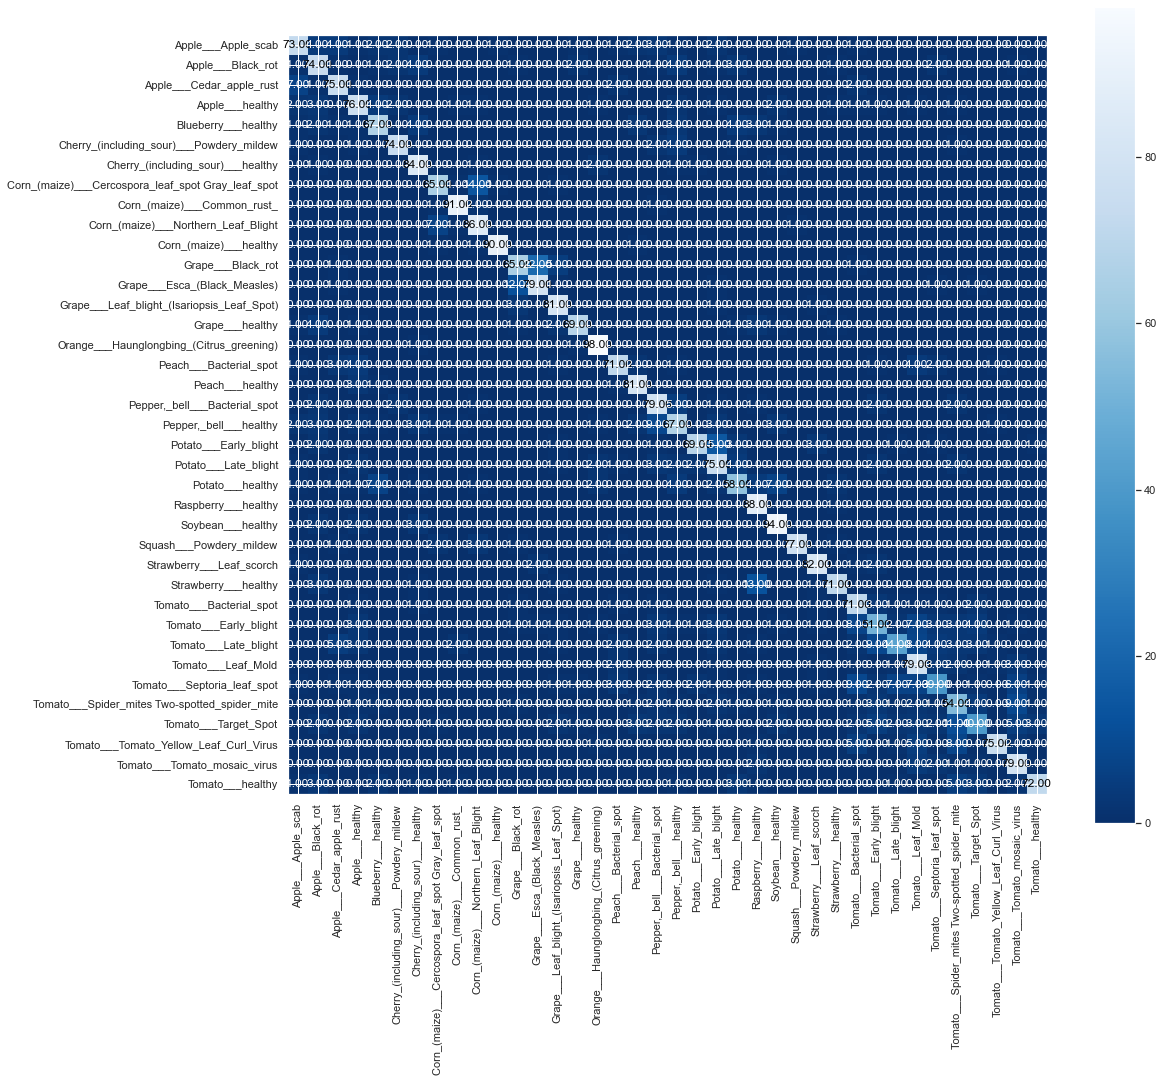

In [18]:
# predicting results of test set from best model and evaluating the prediction

label_names = label_le.classes_
prediction = best_model.predict(test_img)
prediction = np.argmax(prediction,axis=1)
report(prediction, test_label)

### ReaL-Time Prediction

In [21]:
# pass any image path with trained model and this function will predict the result
def predict_image(img_path, model):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(image, (int(98), int(98)))
    img = img/255.
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    predict = np.argmax(predict,axis=1)
    predict = label_le.inverse_transform(predict)
    
    plt.figure(figsize=(6,8))
    plt.imshow(image)
    plt.xlabel(f'Predicted is: "{predict[0]}"')
    plt.show()

1/1 [==============================] - 0s 420ms/step


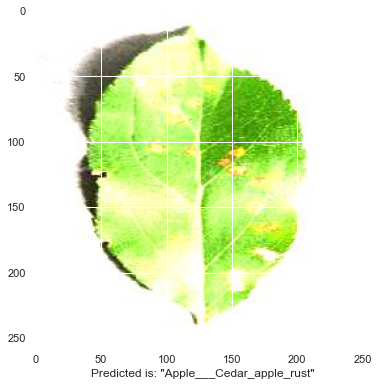

In [22]:
img_path = 'Dataset/test/test/AppleCedarRust1.JPG'
predict_image(img_path, best_model)

1/1 [==============================] - 0s 14ms/step


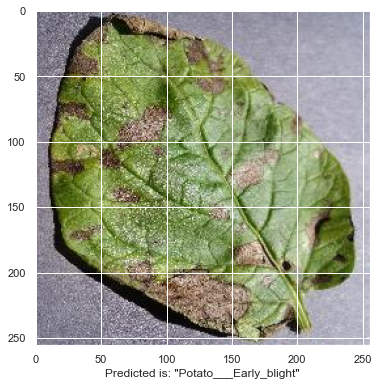

In [23]:
img_path = 'Dataset/test/test/PotatoEarlyBlight1.JPG'
predict_image(img_path, best_model)

1/1 [==============================] - 0s 13ms/step


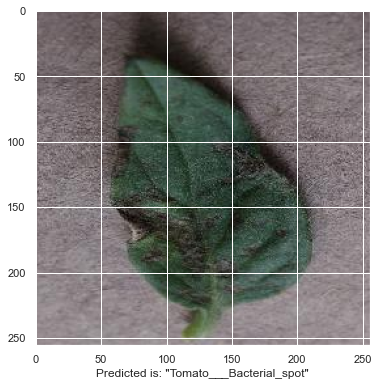

In [24]:
img_path = 'Dataset/test/test/TomatoEarlyBlight6.JPG'
predict_image(img_path, best_model)